# Simulation of BBOB F24

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [1]:
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

sys.path.append('..')
from utils.utils import create_problem, plot_collage, test_function
from utils.optimizer import perform_optimization, plot_optimization
from gt_sampling import get_sample

## Create Groundtruth

In [2]:
n_dim = 2
samples = 1000
seed = 42

problem_f24 = create_problem(24, n_dim, seed)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


## Sample from Groundtruth

In [4]:
sample_f24 = get_sample(problem_f24, n_samples=samples, n_dim=2, seed=42, method='random')

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [5]:
X_input = torch.tensor(sample_f24[0], dtype=torch.float32).clone().detach()
y_input = sample_f24[1].float()  

# input with gradients
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f24[2]), axis=1), dtype=torch.float32).clone().detach()

C:\Users\User\AppData\Local\Temp\ipykernel_5616\1316246691.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(sample_f24[0], dtype=torch.float32).clone().detach()


## Train SVM for Simulation

### Classic SVM

In [6]:
svm_p24 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [7]:
svm_p24.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [9]:
FOLDER = '../models'
pickle.dump(svm_p24, open(f'{FOLDER}/SVM-P24-Classic.pkl', 'wb'))

### SVM with gradients 

In [10]:
svm_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [11]:
# train model with gradients
svm_grad.fit(X_input_grad1, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

In [13]:
pickle.dump(svm_grad, open(f'{FOLDER}/SVM-P24-Grads.pkl', 'wb'))

(estimated by nearest neighbor)

In [14]:
# wrap svm and estimate gradients with nearest neighbor
def svm_grad_1nn(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='nearest_neighbor')

(estimated by GPM)

In [15]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())
gradient_estimator.fit(X_input, X_input_grad1[:, 2:4])

def svm_grad_gpm(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='estimator', gradient_estimator=gradient_estimator)

## Evaluation

### Graphical Evaluation

In [16]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)

mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)


In [18]:
mesh_results_svm_p24 = svm_p24.predict(mesh_samples_tensor).reshape(X1.shape)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

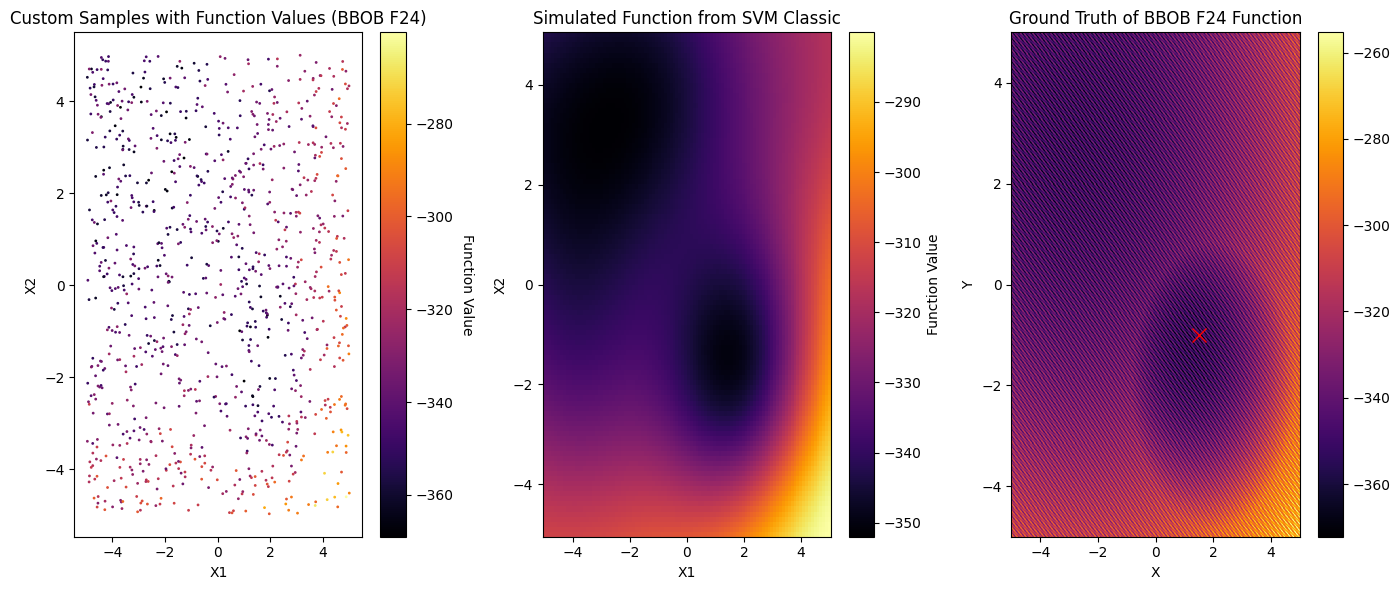

In [19]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", "SVM Classic", X1, X2, mesh_results_svm_p24)

--> on first glance: Classic SVM with RBF-Kernel can capture the 24th BBOB function's global structure quite well. However, the local structure is not represented at all, the model interpolates all local optima

In [20]:
mesh_results_svm_grad_1nn = svm_grad_1nn(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

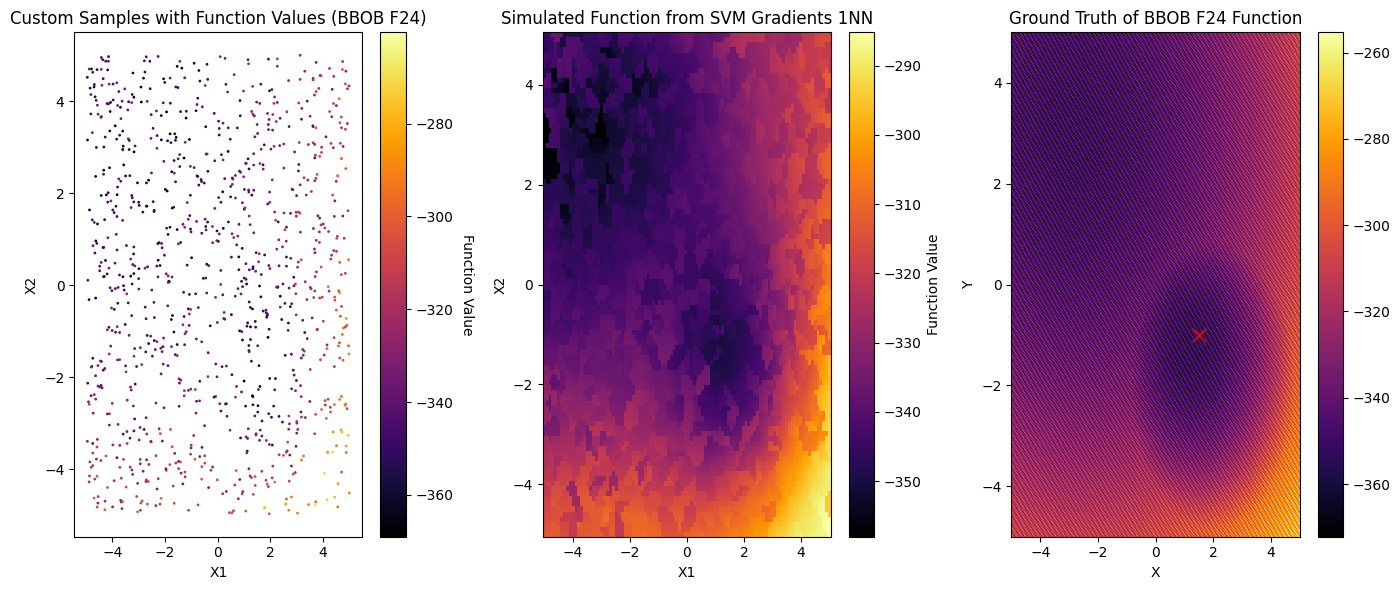

In [22]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", "SVM Gradients 1NN", X1, X2, mesh_results_svm_grad_1nn)

In [23]:
mesh_results_svm_grad_gpm = svm_grad_gpm(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

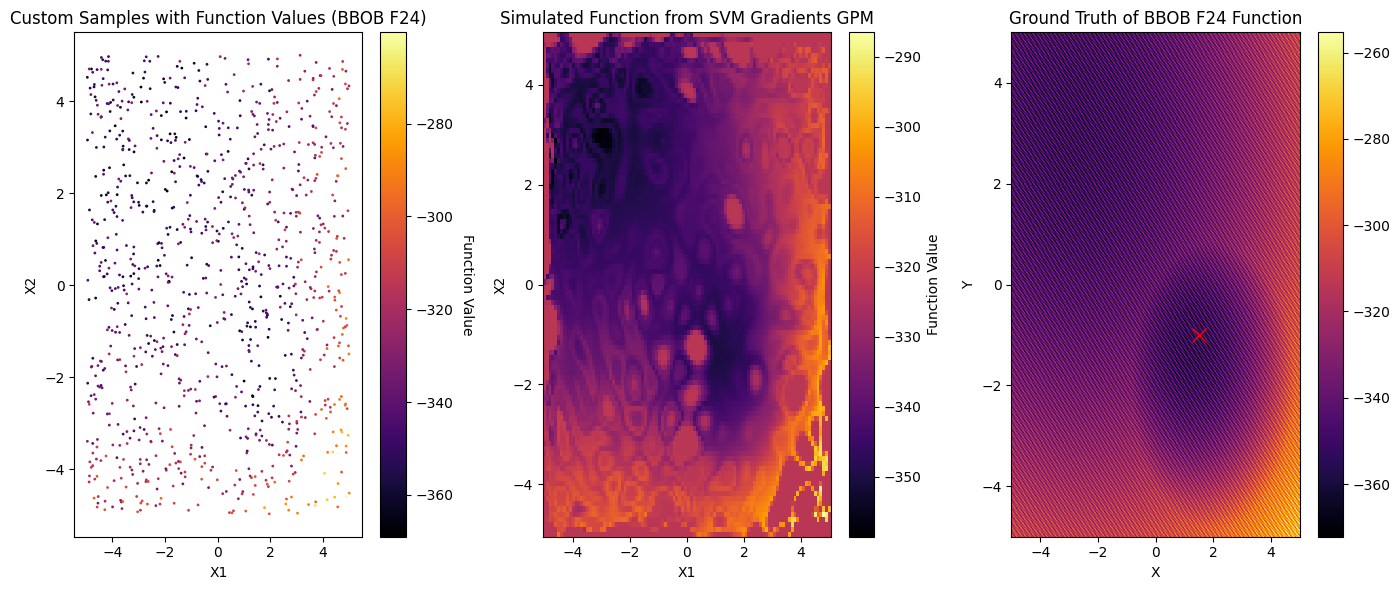

In [24]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", "SVM Gradients GPM", X1, X2, mesh_results_svm_grad_gpm)

### Evaluation with metrics

tbd

### Evaluation with optimizer

In [26]:
svm_classic_f = lambda x: svm_p24.predict(x.reshape(1, -1))
svm_grads_1nn_f = lambda x: svm_grad_1nn(x.reshape(1, -1))
svm_grads_gpm_f= lambda x: svm_grad_gpm(x.reshape(1, -1))
problem_f24_ = lambda x: problem_f24(x.reshape(1,-1))

functions = [
               [problem_f24_, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
             , [svm_grads_1nn_f, 'SVM-Gradients-1NN']
             , [svm_grads_gpm_f, 'SVM-Gradients-GPM']
]

In [33]:
opt = problem_f24(problem_f24.x_opt)[0]
opt

tensor(-355.0294)

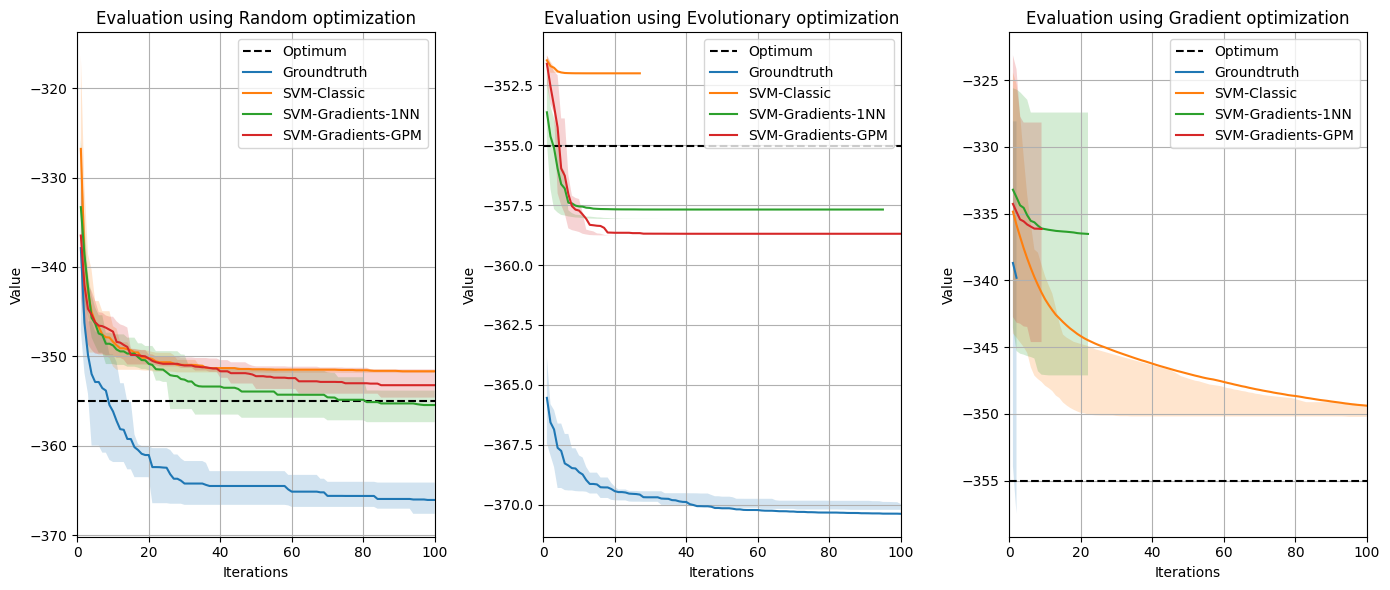

In [28]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100)
plt.subplot(1, 3, 2)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100)
plt.subplot(1, 3, 3)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100)
plt.xlim(0,100)
plt.tight_layout()
plt.show()